In [123]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
import pymannkendall as mk
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [124]:
mydata = pd.read_csv("/Users/amitmishra/Downloads/catfish.csv", parse_dates= ['Date'], index_col = 'Date')

In [125]:
mydata.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


In [126]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
df = mydata[start_date:end_date]


Text(0.5, 0, 'year')

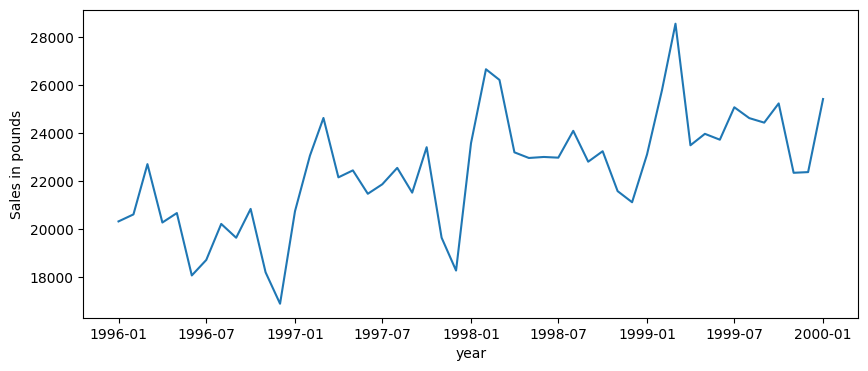

In [127]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.ylabel("Sales in pounds")
plt.xlabel("year")

In [128]:
'''Note that there is difeinitely a bit of seasolity with the upward pattern. There are similar trends in each year, and this is something
we need to account for using the SARIMA model'''

'Note that there is difeinitely a bit of seasolity with the upward pattern. There are similar trends in each year, and this is something\nwe need to account for using the SARIMA model'

## Check for Trend and remove it using differencing if it exists

In [129]:
#lets perform a Mann-Kendall Trend test to confirm the presence of a trend in the data

In [130]:
import pymannkendall as mk

In [131]:
trend_result = mk.original_test(df)

In [132]:
trend_result

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(1.3265938259010568e-06), z=np.float64(4.835727755826662), Tau=np.float64(0.477891156462585), s=np.float64(562.0), var_s=13458.666666666666, slope=np.float64(101.52777777777777), intercept=np.float64(20267.333333333332))

### With h = True and trend = 'increasing' we now know a certain trend exists. So apply differencing

In [133]:
first_diff = df.diff()[1:]

Text(0, 0.5, 'Sales')

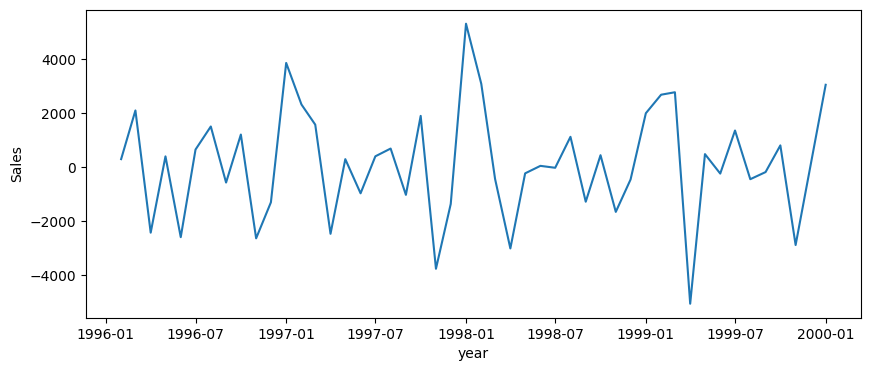

In [134]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.xlabel("year")
plt.ylabel("Sales")

In [135]:
#Now check again for trends and stationary

In [136]:
trend_result_diff = mk.original_test(first_diff)
trend_result_diff

Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.796597408067719), z=np.float64(0.25775317041925105), Tau=np.float64(0.026595744680851064), s=np.float64(30.0), var_s=12658.666666666666, slope=np.float64(4.523200757575758), intercept=np.float64(59.70478219696969))

In [137]:
#Now, the data has no trend and h = False. A high p-value means there is insufficient evidence to reject the null hypothesis of no trend.

### Augmented dickey-fuller test for stationarity

In [138]:
from statsmodels.tsa.stattools import adfuller

In [139]:
adftest = adfuller(first_diff)
print(f"Test statistic:{adftest[0]}\np-value: {adftest[1]}")

Test statistic:-9.515038694170036
p-value: 3.1738387006265344e-16


In [140]:
'''With a low p-value we can reject the null hypothesis that the data is non-stationary. So we may want to use a integrated order of 1 as taking
first difference seems to make it stationary. ''' 

'With a low p-value we can reject the null hypothesis that the data is non-stationary. So we may want to use a integrated order of 1 as taking\nfirst difference seems to make it stationary. '

### ACF

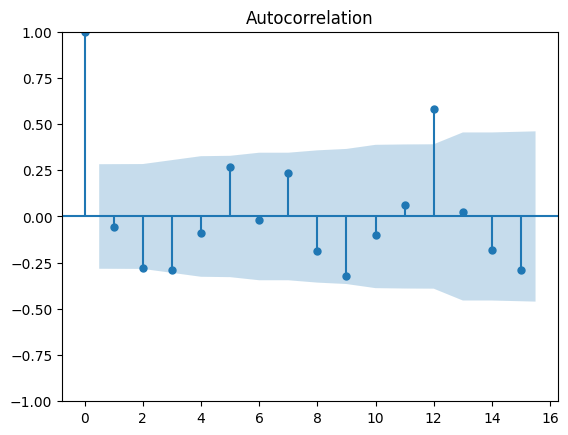

In [141]:
acf_val = plot_acf(first_diff, lags = 15, alpha = 0.05)

### Based on ACF we should start with season MA process with a lag or 12 months or one year. 

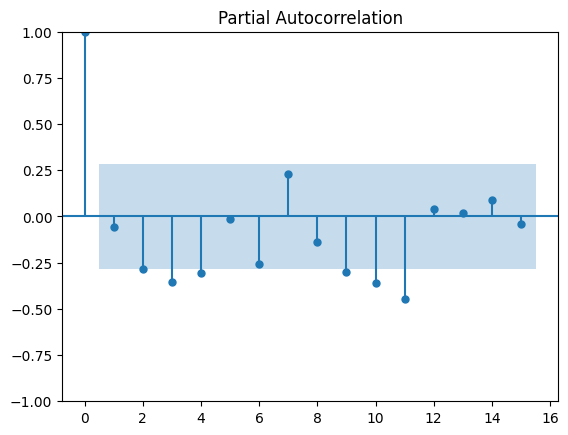

In [142]:
pacf_val = plot_pacf(first_diff, lags = 15, alpha = 0.05)

In [143]:
#Train and test data

In [144]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1): test_end]

# Fit the SARIMA model

In [145]:
my_order = (0,1,0)
my_seasonal_order = (1,0,1,12)

In [146]:
model1 = SARIMAX(train_data, order = my_order, seasonal_order=my_seasonal_order).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87212D+00    |proj g|=  1.21410D+00

At iterate    5    f=  8.58482D+00    |proj g|=  3.02732D-01

At iterate   10    f=  8.55809D+00    |proj g|=  1.37586D-03

At iterate   15    f=  8.55808D+00    |proj g|=  1.03619D-03

At iterate   20    f=  8.55792D+00    |proj g|=  2.65464D-02

At iterate   25    f=  8.53971D+00    |proj g|=  1.20691D-01

At iterate   30    f=  8.51109D+00    |proj g|=  3.57081D-02

At iterate   35    f=  8.50315D+00    |proj g|=  5.67697D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


In [147]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Mon, 25 Nov 2024   AIC                            737.269
Time:                                      20:40:47   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.5187      0.197     -2.632      0.008      -0.905      -0.132
sigma2       1.78e+06    4.7e+05      3.791      0.000     8.6e+05     2.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.82   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.09   Prob(JB):                         0.57
Heteroskedasticity (H):               0.81   Skew:                            -0.30
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
#Let's make some predictions and calculate the residuals

In [169]:
predictions1 = model1.forecast(len(test_data))
predictions1 = pd.Series(predictions1, index = test_data.index)
test_data_series = test_data.squeeze()
residuals1 = test_data_series - predictions1 

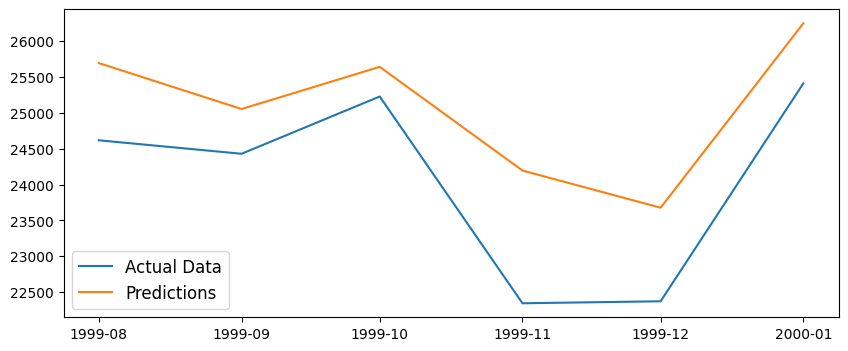

In [190]:
plt.figure(figsize= (10,4))
plt.plot(test_data)
plt.plot(predictions1)
plt.legend(("Actual Data", "Predictions"), fontsize = 12)

In [ ]:
#Our predictions are matching the shape, but we are always overpredicting. Part of this is trying to predict a lot of periods in advance.

Text(0.5, 1.0, 'Residuals from SARIMA model')

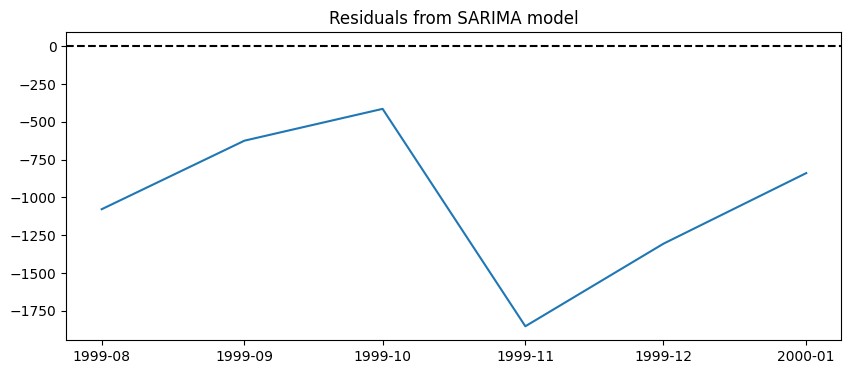

In [174]:
plt.figure(figsize = (10,4))
plt.plot(residuals1)
plt.axhline(0, linestyle='--', color='k')
plt.title("Residuals from SARIMA model")


In [187]:
print(f"RMSE: {np.sqrt(np.mean(residuals1**2))}")

RMSE: 1122.3069103233538


In [189]:
print(f"Mean absolute percentage error: {np.mean(np.abs(residuals1/test_data_series))}")

Mean absolute percentage error: 0.04332291620899304


In [ ]:
#A MAPE of 4% is generally considered good in retail